 # MTH8408 : Méthodes d'optimisation et contrôle optimal
 ## Laboratoire 5: Optimisation avec contraintes et calcul variationnel
Tangi Migot et Paul Raynaud
Rédigé par Adam Osmani

In [1]:
using Krylov, LinearAlgebra, Logging, NLPModels, NLPModelsIpopt, Printf, SolverCore, Test

In [2]:
import Pkg; Pkg.add("PDENLPModels")
import Pkg; Pkg.add("Gridap")
using PDENLPModels, Gridap


   Resolving package versions...
  No Changes to `C:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\Project.toml`
  No Changes to `C:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\Manifest.toml`
Precompiling project...
  ? PDENLPModels
   Resolving package versions...
  No Changes to `C:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\Project.toml`
  No Changes to `C:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\Manifest.toml`
Precompiling project...
  ? PDENLPModels
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


## Quelques commentaires en Julia

### Les kwargs: choix optionnels

Dans le projet du dernier labo, une des questions demandait d'ajouter une option pour utiliser la fonction `lsmr` ou `lsqr`. C'est le cas typique d'arguments optionnels:
- On veut proposer un choix par défaut à l'utilisateur, par exemple `lsqr`;
- On veut laisser la possibilité à l'utilisateur de changer;
- On voudrait aussi pouvoir ajouter d'autres par la suite (sans avoir à tout modifier).

In [3]:
function dsol(A, b, ϵ; solver :: Function = lsqr)
    (d, stats) = solver(A, b, atol = ϵ)
    return d
end

dsol (generic function with 1 method)

A noter que l'on donne des valeurs par défaut aux arguments qui apparaissent après le `;`.

## Exercice 1: Pénalité quadratique pour les ADNLPModels

Dans cet exercice, on va étudier une version simple d'une méthode de pénalité quadratique pour les problèmes d'optimisation avec contraintes d'égalité.
```math
min f(x) s.à c(x) = 0.
```
Dans les labos précédents, on a déjà utilisé un NLPModel particulier, le ADNLPModel:

In [4]:
using ADNLPModels, LinearAlgebra, Test
fH(x) = (x[2]+x[1].^2-11)^2 + (x[1]+x[2].^2-7)^2
x0H = [10., 20.]
cH(x) = [x[1]-1]
himmelblau = ADNLPModel(fH, x0H, cH, [0.], [0.])

ADNLPModel - Model with automatic differentiation backend ADNLPModels.ForwardDiffAD{ForwardDiff.GradientConfig{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2}}}}(3, 2, ForwardDiff.GradientConfig{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2}}}((Partials(1.0, 0.0), Partials(0.0, 1.0)), ForwardDiff.Dual{ForwardDiff.Tag{typeof(fH), Float64}, Float64, 2}[Dual{ForwardDiff.Tag{typeof(fH), Float64}}(1.000782451328e-311,6.95269636110307e-310,1.000782451336e-311), Dual{ForwardDiff.Tag{typeof(fH), Float64}}(6.95269636110307e-310,1.000782451344e-311,6.95269636110307e-310)]))
  Problem name: Generic
   All variables: ████████████████████ 2      All constraints: ████████████████████ 1     
            free: ████████████████████ 2                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅

Attention: dans toute la suite de l'exercice on suppose que les bornes sur les contraintes `nlp.meta.lcon` et `nlp.meta.ucon` sont 0 pour simplifier.

### Question 1: Transformer un ADNLPModel en un problème pénalisé
Coder la fonction `quad_penalty_adnlp` qui prend en entrée un ADNLPModel, et un paramètre ρ et qui retourne un nouveau ADNLPModel qui correspond au problème sans contrainte:
$$
\min_x f(x) + \frac{\rho}{2}\|c(x)\|^2.
$$
Remarque: on peut accèder aux fonctions f et c par `NLPModels.obj()` et `NLPModels.cons()`.

In [5]:
function quad_penalty_adnlp(nlp :: ADNLPModel, ρ :: Real)
    # TODO
    f(x) = obj(nlp,x) + ρ/2*norm(cons(nlp,x))^2
    x0 = nlp.meta.x0
    nlp_quad = ADNLPModel(f,x0)

    if((nlp.meta.lcon ≠ [0.0]) || (nlp.meta.ucon ≠ [0.0]))
        print("lcon or ucon not equal to 0.0\n")
        print("lcon: ",nlp.meta.lcon,"\n")
        print("ucon: ",nlp.meta.ucon,"\n")
    end

   return nlp_quad
end

quad_penalty_adnlp (generic function with 1 method)

In [6]:
#Faire des tests pour vérifier que ça fonctionne.
#= fH(x) = (x[2]+x[1].^2-11).^2+(x[1]+x[2].^2-7).^2
x0H = [10., 20.]
himmelblau = ADNLPModel(fH, x0H) =#

himmelblau_quad = quad_penalty_adnlp(himmelblau, 1)
@test himmelblau_quad.meta.ncon == 0
@test obj(himmelblau_quad, zeros(2)) == 170.5


Test Passed

In [7]:
#Ajouter au moins un autre test similaire avec des contraintes.

In [8]:
# Ajouter un test au cas ou `nlp.meta.lcon` ou `nlp.meta.ucon` ont des composantes differentes de 0.


### Question 2: KKT
Coder une fonction `KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ)` qui vérifie si le point `x` avec multiplicateur de Lagrange `λ` satisfait les conditions KKT d'un problème avec contraintes d'égalités.

In [9]:
function KKT_eq_constraint(nlp :: AbstractNLPModel, x, λ)
   # TODO
   cx = cons(nlp,x)
   gfx = grad(nlp,x)
   gcx = grad(cx,x)
   if(gfx == dot(λ,gcx))
      return true
   else
      return false
   end
end

KKT_eq_constraint (generic function with 1 method)

In [10]:
#test
using NLPModelsIpopt
stats = ipopt(himmelblau)
KKT_eq_constraint(himmelblau,stats.solution,himmelblau.meta.y0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality c

MethodError: MethodError: no method matching grad(::Vector{Float64}, ::Vector{Float64})

Closest candidates are:
  grad(!Matched::AbstractNLPModel, ::AbstractVector)
   @ NLPModels C:\Users\adamo\.julia\packages\NLPModels\XBcWL\src\nlp\api.jl:28


### Question 3: méthode de pénalité quadratique

In [11]:
using NLPModelsIpopt

In [12]:
function quad_penalty(nlp      :: AbstractNLPModel,
                      x        :: AbstractVector; 
                      ϵ        :: AbstractFloat = 1e-3,
                      η        :: AbstractFloat = 1e6, 
                      σ        :: AbstractFloat = 2.0,
                      max_eval :: Int = 1_000, 
                      max_time :: AbstractFloat = 60.,
                      max_iter :: Int = typemax(Int64)
                      )
    ##### Initialiser cx et gx au point x;
    cx = cons(nlp,x)# Initialiser la violation des contraintes
    gx = grad(nlp,x)# Initialiser le gradient
    ######################################################
    normcx = normcx_old = norm(cx)

    ρ = 1.

    iter = 0    

    el_time = 0.0
    tired   = neval_cons(nlp) > max_eval || el_time > max_time
    status  = :unknown

    start_time = time()
    too_small  = false
    normdual   = norm(gx) #exceptionnellement on ne va pas vérifier toute l'optimalité au début.
    optimal    = max(normcx, normdual) ≤ ϵ
    
    nlp_quad   = quad_penalty_adnlp(nlp, ρ)

    @info log_header([:iter, :nf, :primal, :status, :nd, :Δ],
    [Int, Int, Float64, String, Float64, Float64],
    hdr_override=Dict(:nf => "#F", :primal => "‖F(x)‖", :nd => "‖d‖"))

    while !(optimal || tired || too_small)

        #Appeler Ipopt pour résoudre le problème pénalisé en partant du point x0 = x.
        #utiliser l'option print_level = 0 pour enlever les affichages d'ipopt.
        stats = ipopt(nlp, x0 = x, print_level = 0)#...
        ################################################
      
        if stats.status == :first_order
            ###### Mettre à jour cx avec la solution renvoyé par Ipopt
            x = stats.solution#...
            cx = cons(nlp,x)#...
            ##########################################################
            normcx_old = normcx
            normcx = norm(cx)
        end
        
        if normcx_old > 0.95 * normcx
            ρ *= σ
        end

        @info log_row(Any[iter, neval_cons(nlp), normcx, stats.status])
        
        nlp_quad   = quad_penalty_adnlp(nlp, ρ)

        el_time      = time() - start_time
        iter   += 1
        many_evals   = neval_cons(nlp) > max_eval
        iter_limit   = iter > max_iter
        tired        = many_evals || el_time > max_time || iter_limit || ρ ≥ η
        ##### Utiliser la réalisabilité dual renvoyé par Ipopt pour `normdual`
        normdual     = stats.dual_feas#....
        ###################################################################
        optimal      = max(normcx, normdual) ≤ ϵ
    end

    status = if optimal 
        :first_order
    elseif tired
        if neval_cons(nlp) > max_eval
            :max_eval
        elseif el_time > max_time
            :max_time
        elseif iter > max_iter
            :max_iter
        else
            :unknown_tired
        end
    elseif too_small
        :stalled
    else
        :unknown
    end

    return GenericExecutionStats(nlp, status = status, solution = x,
                                 objective = obj(nlp, x),
                                 primal_feas = normcx,
                                 dual_feas = normdual,
                                 iter = iter, 
                                 elapsed_time = el_time,
                                 solver_specific = Dict(:penalty => ρ))
end

quad_penalty (generic function with 1 method)

In [13]:
#Faire des tests pour vérifier que ça fonctionne.
stats = quad_penalty(himmelblau, x0H)
@test stats.status == :first_order
@test stats.solution ≈ [1.0008083416169895, 2.709969135758311] atol=1e-2
@test norm(cons(himmelblau, stats.solution)) ≈ 0. atol=1e-3

┌ Info:   iter      #F    ‖F(x)‖           status       ‖d‖         Δ  
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:31
┌ Info:      0      24   0.0e+00      first_order
└ @ Main c:\Users\adamo\OneDrive\Documents\POLY\H24\MTH8408\MTH8408-Hiv24\lab5\Lab5-notebook.ipynb:55


Test Passed

Vérifier que la solution rendue vérifie les conditions KKT avec la fonction de la question précédente.

In [14]:
# TODO

In [15]:
#Fichier de tests à demander.
KKT_eq_constraint(himmelblau,stats.solution,himmelblau.meta.y0)

MethodError: MethodError: no method matching grad(::Vector{Float64}, ::Vector{Float64})

Closest candidates are:
  grad(!Matched::AbstractNLPModel, ::AbstractVector)
   @ NLPModels C:\Users\adamo\.julia\packages\NLPModels\XBcWL\src\nlp\api.jl:28


## Exercice 2: Calcul Variationnel

Dans cet exercice, on considère le problème de calcul variationnel suivant:
$$
\min \int_0^1 (\dot{x}(t)^2+2x(t)^2)e^t dt, \quad x(0)=0, x(1)=e - e^{-2}
$$

modélisé avec `PDENLPModels`.

In [16]:
function cv_model(n :: Int)

  domain = (0,1) # set the domain
  partition = n
  model = CartesianDiscreteModel(domain,partition) # set discretization
    
  labels = get_face_labeling(model)
  add_tag_from_tags!(labels,"diri1",[2])
  add_tag_from_tags!(labels,"diri0",[1]) # boundary conditions

  order=1
  valuetype=Float64
  reffe = ReferenceFE(lagrangian, valuetype, order)
  V0 = TestFESpace(model, reffe; conformity=:H1, dirichlet_tags=["diri0","diri1"])
  U = TrialFESpace(V0,[0., exp(1)-exp(-2)])

  trian = Triangulation(model)
  degree = 2
  dΩ = Measure(trian,degree) # integration machinery

  # Our objective function
  w(x) = exp(x[1])
  function f(y)
    ∫((∇(y)⊙∇(y) + 2 * y * y) * w) * dΩ
  end

  xin = zeros(Gridap.FESpaces.num_free_dofs(U))
  nlp = GridapPDENLPModel(xin, f, trian, U, V0)
  return nlp
end

cv_model (generic function with 1 method)

### Question 1: Résoudre
Résoudre le NLPModel généré par la fonction `cv_model` pour `n = 16` avec `ipopt` et afficher la solution (attention la solution rendue ne contient pas les valeurs aux bords qu'il faut rajouter).

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       44

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8202747e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

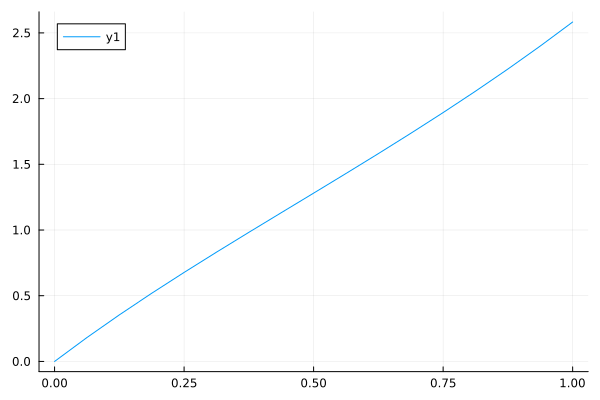

In [17]:
# TODO
using Plots
cv16 = cv_model(16)
stats = ipopt(cv16)

x = range(0,1,length = 17)
y = [0;stats.solution;exp(1)-exp(-2)]
plot(x,y)

### Question 2: Convergence en `n`
Afficher sur un même graphique la solution obtenue par `ipopt` pour plusieurs valeurs de `n`.

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       44

Total number of variables............................:       15
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8202747e+02 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

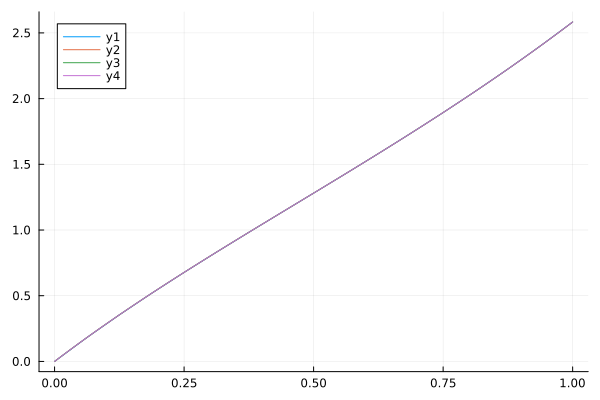

In [18]:
n = 16
cv = cv_model(n)
stats = ipopt(cv)

x = range(0,1,length=(n+1))
y = [0;stats.solution;exp(1)-exp(-2)]
plot(x,y)

n = 64
cv = cv_model(n)
stats = ipopt(cv)

x = range(0,1,length=(n+1))
y = [0;stats.solution;exp(1)-exp(-2)]
plot!(x,y)

n = 128
cv = cv_model(n)
stats = ipopt(cv)

x = range(0,1,length=(n+1))
y = [0;stats.solution;exp(1)-exp(-2)]
plot!(x,y)

x = range(0,1,length=128)
y = exp.(x) - exp.(-2*x)
plot!(x,y)

### Question 3: Comparer à la solution exacte

La solution exacte est $x(t)=e^t - e^{-2t}$ et la valeur optimale est $e^3 - 2e^{-3}+1$.

In [20]:
## Exercice 1
#
using ADNLPModels, OptimizationProblems, JuMP
nlp = BOX2()
@test nlp.meta.ncon != 0

nlp_quad = quad_penalty_adnlp(nlp, 1)
@test nlp_quad.meta.ncon == 0


UndefVarError: UndefVarError: `BOX2` not defined